In [131]:
# Imports
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm
import datetime


In [132]:
# Download stock data from Yahoo Finance
hmc_data = yf.download('HMC', period='10y')['Close']
hymtf_data = yf.download('HYMTF', period='10y')['Close']
spread = hmc_data - hymtf_data

# Slice the data into the formation period, This is the period we will use to form the historical distribution of pct_change
hmc_formation = hmc_data.loc['2011-01-01':'2016-01-01']
hymtf_formation = hymtf_data.loc['2011-01-01':'2016-01-01']
spread_formation = hmc_formation - hymtf_formation


# Slice the data into the testing period, This is the period we will use to test the strategy
hmc_testing = hmc_data.loc['2016-01-01':'2019-01-01']
hymtf_testing = hymtf_data.loc['2016-01-01':'2019-01-01']
spread_testing = hmc_testing - hymtf_testing


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


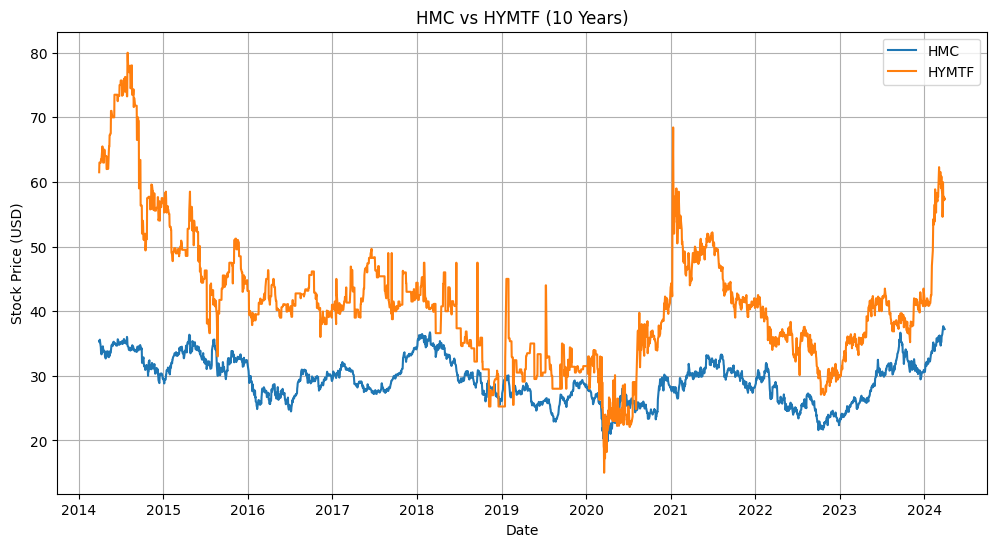

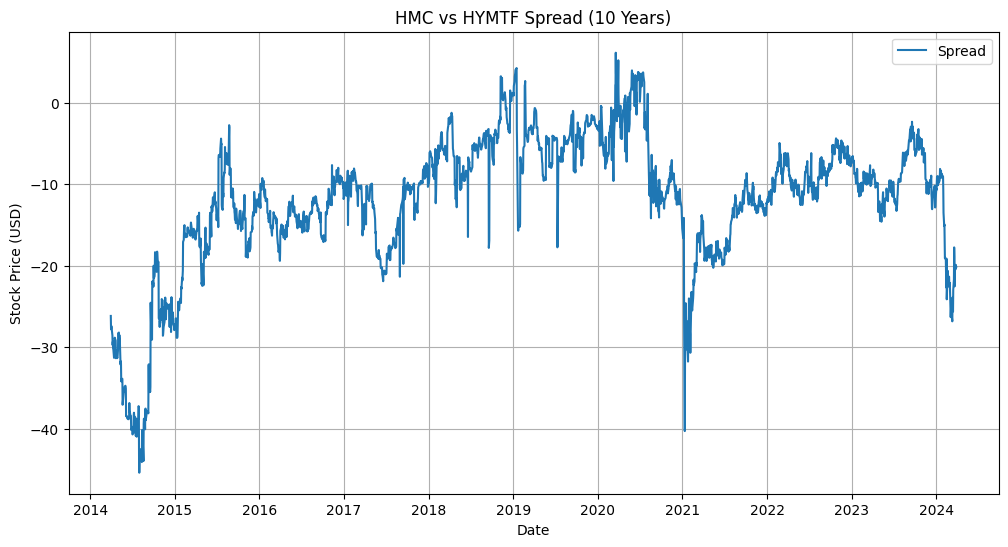

In [133]:
# Plot the 'Close' data:
plt.figure(figsize=(12, 6))
plt.plot(hmc_data, label='HMC')
plt.plot(hymtf_data, label='HYMTF')
plt.title('HMC vs HYMTF (10 Years)')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Plot the spread data:
plt.figure(figsize=(12, 6))
plt.plot(spread, label='Spread')
plt.title('HMC vs HYMTF Spread (10 Years)')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

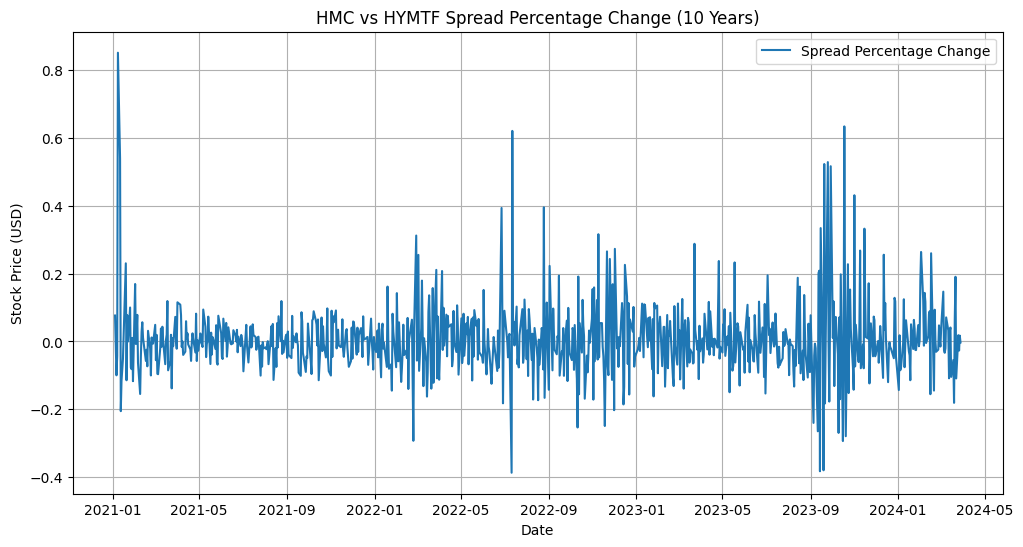

In [134]:
spread_pct_change = spread.pct_change().dropna()    # Contains outlier
spread_pct_change_slice = spread_pct_change['2021-01-01':]  # Slice the data to remove the outlier

# Plot the spread percentage change data:
plt.figure(figsize=(12, 6))
plt.plot(spread_pct_change_slice, label='Spread Percentage Change')
plt.title('HMC vs HYMTF Spread Percentage Change (10 Years)')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.show()




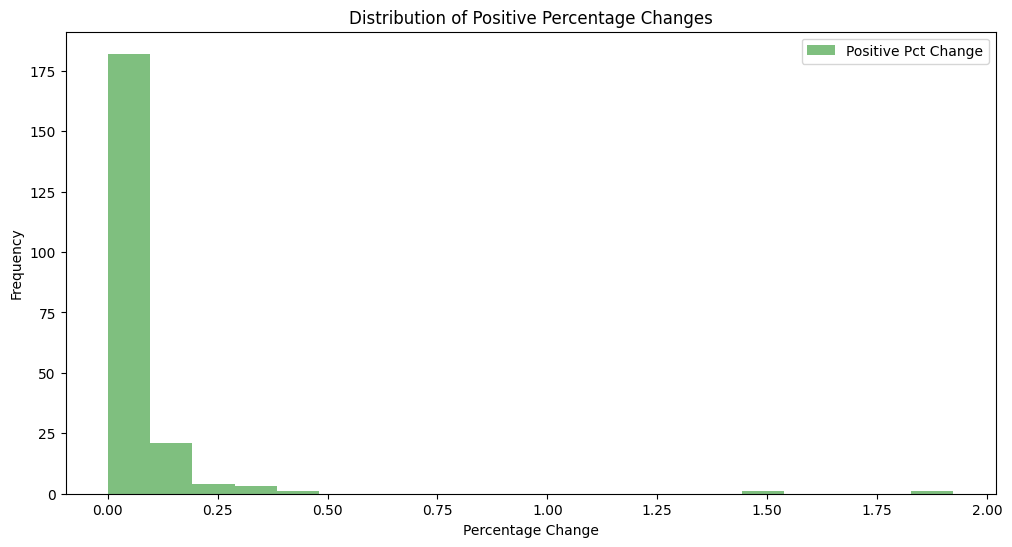

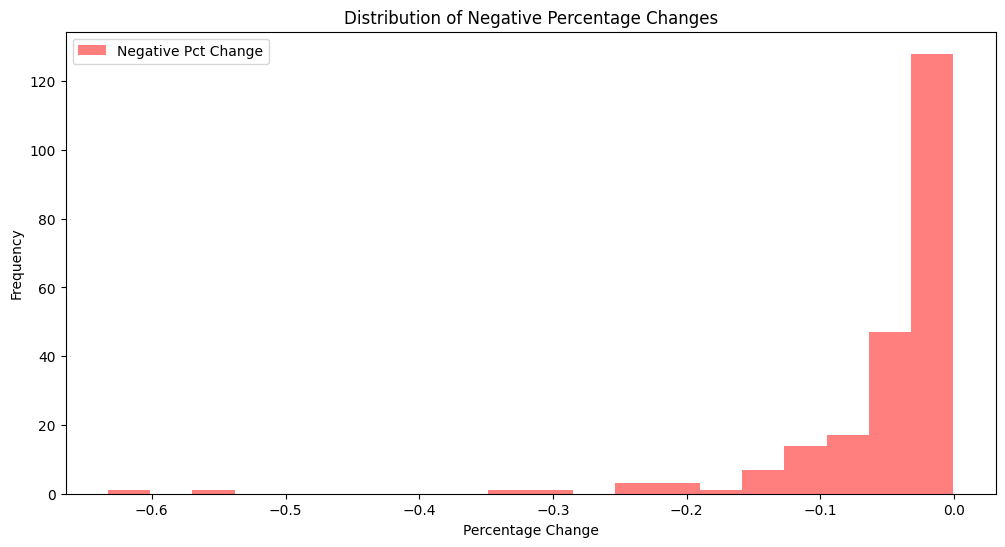

In [135]:
# Calculate the spread formation period percentage change distributions
formation_spread_pct_change = spread_formation.pct_change().dropna()
formation_pct_change_pos = formation_spread_pct_change[formation_spread_pct_change > 0]
top_decile = formation_pct_change_pos.quantile(0.9)
top_quintile = formation_pct_change_pos.quantile(0.8)

formation_pct_change_neg = formation_spread_pct_change[formation_spread_pct_change < 0]
bottom_decile = formation_pct_change_neg.quantile(0.1)
bottom_quintile = formation_pct_change_neg.quantile(0.2)

# Create the first figure for positive percentage change histogram
plt.figure(figsize=(12, 6))
plt.hist(formation_pct_change_pos, bins=20, color='green', alpha=0.5, label='Positive Pct Change')
plt.title('Distribution of Positive Percentage Changes')
plt.xlabel('Percentage Change')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Create the second figure for negative percentage change histogram
plt.figure(figsize=(12, 6))
plt.hist(formation_pct_change_neg, bins=20, color='red', alpha=0.5, label='Negative Pct Change')
plt.title('Distribution of Negative Percentage Changes')
plt.xlabel('Percentage Change')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [136]:
# Neighborhood for regression to prevent overfitting
NEIGHBORHOOD = 10

# This is not correct but will do for simplicity for now
# ALPHAS should be determined by whatever combination of top and bottom decile/quintile maximise the returns
ALPHA_LONG = top_decile
ALPHA_SHORT = bottom_decile

NUM_SHARES = 50 # Number of shares to buy/sell, arbitrary num for now
position_open = False
position_type = None
trades = [] # List of trade objects which are dicts

# Backtest the strategy
for end_row in range(NEIGHBORHOOD, len(spread_testing)):
    # Get the current data slice
    cur_hmc_data = hmc_testing[:end_row]
    cur_hymtf_data = hymtf_testing[:end_row]
    # Calculate the spread
    cur_spread_data = cur_hymtf_data - cur_hmc_data

    # Get the neighborhood window for the spreads
    neighborhood_window = cur_spread_data[-NEIGHBORHOOD:]
    neighborhood_window.index = neighborhood_window.index.astype(int) / 10 ** 9

    # Fit a line to the neighborhood window
    m, c = np.polyfit(neighborhood_window.index, neighborhood_window, 1)
    y_pred = (m * neighborhood_window.index + c)
    y_pred = pd.Series(y_pred, index=neighborhood_window.index)
    y_pred.index = pd.to_datetime(y_pred.index, unit='s', origin='unix')
    
    # Calculate the pct change between current spread and forecastied spread
    predicted_spread = y_pred.iloc[-1]
    cur_spread = cur_spread_data.iloc[-1]
    predicted_pct_change = ((predicted_spread - cur_spread) / cur_spread) * 100


    # Check if we should open a position using conditionials from the book
    if not position_open:
        if predicted_pct_change > ALPHA_LONG:
            position_open = True
            position_type = 'LONG'
            position_open_date = cur_spread_data.index[-1]
            position_open_price = cur_spread_data.iloc[-1]
            print(f'Opened {position_type} position on {position_open_date} at {position_open_price}')
            trade = {
                'open_date': position_open_date,
                'open_price': position_open_price,
                'position_type': position_type,
                'shares': NUM_SHARES
            }
        elif predicted_pct_change < ALPHA_SHORT:
            position_open = True
            position_type = 'SHORT'
            position_open_date = cur_spread_data.index[-1]
            position_open_price = cur_spread_data.iloc[-1]
            print(f'Opened {position_type} position on {position_open_date} at {position_open_price}')
            trade = {
                'open_date': position_open_date,
                'open_price': position_open_price,
                'position_type': position_type,
                'shares': NUM_SHARES
            }
    elif position_open:
        if position_type == 'LONG' and predicted_pct_change > ALPHA_SHORT and predicted_pct_change < 0:
            position_open = False
            position_close_date = cur_spread_data.index[-1]
            position_close_price = cur_spread_data.iloc[-1]
            print(f'Closed {position_type} position on {position_close_date} at {position_close_price}')
            trade['close_date'] = position_close_date
            trade['close_price'] = position_close_price
            trades.append(trade)
        elif position_type == 'SHORT' and predicted_pct_change < ALPHA_LONG and predicted_pct_change > 0:
            position_open = False
            position_close_date = cur_spread_data.index[-1]
            position_close_price = cur_spread_data.iloc[-1]
            print(f'Closed {position_type} position on {position_close_date} at {position_close_price}')
            trade['close_date'] = position_close_date
            trade['close_price'] = position_close_price
            trades.append(trade)

# Calculate the PnL for each trade
trades_df = pd.DataFrame(trades)
trades_df['pnl/trade'] = (trades_df['close_price'] * NUM_SHARES) - (trades_df['open_price'] * NUM_SHARES)
trades_df['pnl'] = trades_df['pnl/trade'].cumsum()  # Cumulative PnL
trades_df.to_csv('trades.csv')  # Save trades to csv

Opened SHORT position on 2016-01-15 00:00:00 at 10.170000076293945
Closed SHORT position on 2016-04-27 00:00:00 at 15.230001449584961
Opened SHORT position on 2016-04-28 00:00:00 at 16.470001220703125
Closed SHORT position on 2016-09-29 00:00:00 at 16.76999855041504
Opened LONG position on 2016-09-30 00:00:00 at 16.67999839782715
Closed LONG position on 2016-12-07 00:00:00 at 7.979999542236328
Opened SHORT position on 2016-12-08 00:00:00 at 9.779998779296875
Closed SHORT position on 2017-02-27 00:00:00 at 10.960000991821289
Opened SHORT position on 2017-02-28 00:00:00 at 11.230001449584961
Closed SHORT position on 2017-06-12 00:00:00 at 20.270000457763672
Opened LONG position on 2017-06-13 00:00:00 at 20.170000076293945


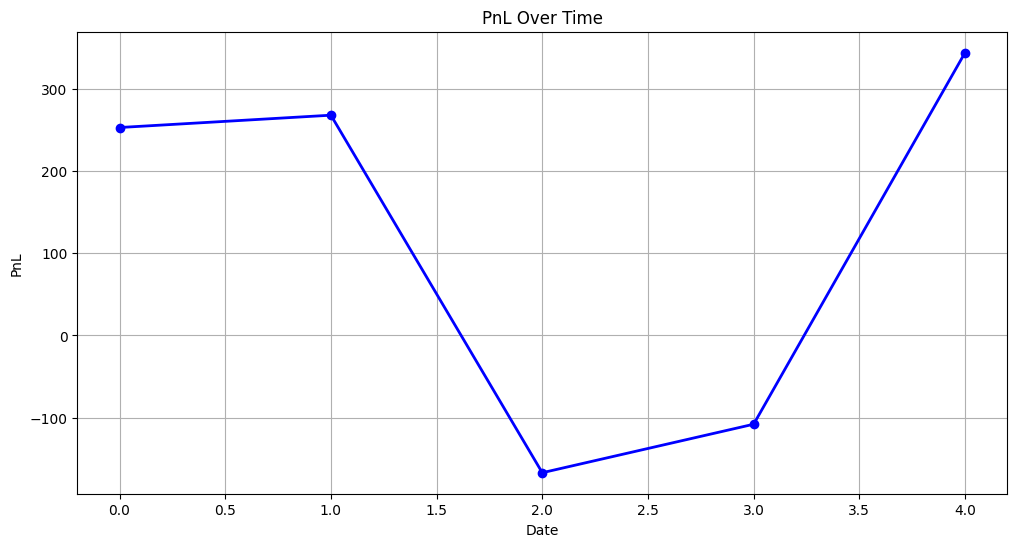

In [137]:
# Plot cumulative PnL over time
plt.figure(figsize=(12, 6))
plt.plot(trades_df.index, trades_df['pnl'], marker='o', color='blue', linewidth=2)
plt.title('PnL Over Time')
plt.xlabel('Date')
plt.ylabel('PnL')
plt.grid(True)
plt.show()
